In [20]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
from imports import (fct, datetime, xr, units, mpcalc, plt, SkewT)

# reload imports
%load_ext autoreload
%autoreload 2


# plotting cosmetics
fct.plot_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
savefig = 0   # 1=yes, 0=no
form = 'png'

# File direction where figures should be saved (to be changed)
#figdir = 'sftp://franzihe@login.uio.no/uio/kant/geo-metos-u1/franzihe/www_docs'
figdir = '/home/franzihe/Documents/Figures/Weathermaps'

In [2]:
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
date = now.strftime("%Y%m%d")
time = now.strftime('%H')
print("date and time =", date, time)	


date and time = 20210223 14


In [3]:
forecast_in_hours = 12

In [4]:
ini_time = '09'

In [93]:
#  Open the netCDF file containing the input data.
fnx = xr.open_dataset('https://thredds.met.no/thredds/dodsC/mepslatest/meps_det_2_5km_%sT%sZ.ncml' %(date, ini_time), decode_times  = True, use_cftime = True)

In [6]:
# Pick out area around 400km to Andenes
# Nordmela Coordinates: 69.1358N, 15.6776E
nordmela_lat = 69.135840; nordmela_lon = 15.677645
lower_lat = 64.83; lower_lon = 0.98
upper_lat = 74.85;  upper_lon = 5.45

In [7]:
X, Y = fct.find_yx(fnx.latitude, fnx.longitude,nordmela_lat, nordmela_lon,)

In [65]:
# air temperature in model levels
T = (fnx.air_temperature_ml.sel(x = X, y = Y, method = 'nearest').isel(time = forecast_in_hours) -273.15).values *units.degC

# pressure in model levels
##  p(n,k,j,i) = ap(k) + b(k)*ps(n,j,i)
## formula_terms: ap: ap b: b ps: surface_air_pressure p0: p0
P = ((fnx.ap + fnx.b * fnx.surface_air_pressure.sel(x = X, y = Y, method = 'nearest').isel(time = forecast_in_hours, height0 =0))*0.01).values * units.hPa
#P = fnx.pressure.values *units(fnx.pressure.attrs['units'])

# specific humidity
qv = (fnx.specific_humidity_ml.sel(x = X, y = Y, method = 'nearest').isel(time = forecast_in_hours)).values * units(fnx.specific_humidity_ml.attrs['units'])

# wind x and y
u = fnx.x_wind_ml.sel(x = X, y = Y, method = 'nearest').isel(time = forecast_in_hours).values * units(fnx.x_wind_ml.attrs['units'])
v = fnx.y_wind_ml.sel(x = X, y = Y, method = 'nearest').isel(time = forecast_in_hours).values * units(fnx.y_wind_ml.attrs['units'])

# calculate the dewpoint by first calculating the relative humidity from the specific humidity
rh = mpcalc.relative_humidity_from_specific_humidity(P,T,qv)
# now the dewpoint
Td = mpcalc.dewpoint_from_relative_humidity(T, rh)

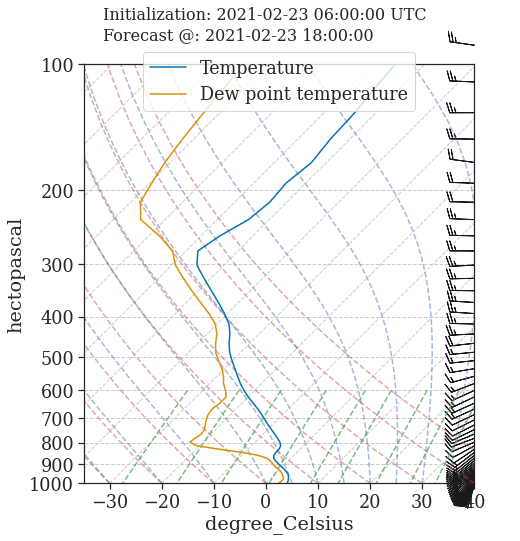

In [122]:
fig = plt.figure(figsize = (7,9))
# plot skewT for ..UTC
skew = SkewT(fig, rotation = 45, subplot =111)

skew.plot(P, T,label = 'Temperature' )
skew.plot(P, Td, label = 'Dew point temperature')
skew.plot_barbs(P, u, v)

skew.ax.set_ylim(1000, 100)
# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Good bounds for aspect ratio
skew.ax.set_xlim(-35, 40)
skew.ax.text(0.05, 1.05, 'Initialization: {} UTC \nForecast @: {}'.format(str(fnx.forecast_reference_time.values), str(fnx.time.isel(time = forecast_in_hours).values)), 
                                                                              transform=skew.ax.transAxes,
                 fontsize=16, verticalalignment='bottom',)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=1,
           fancybox = True, facecolor = 'white',  title_fontsize = 14)

if savefig == 1:
    fig_name = '{}'.format(str(fnx.time.isel(time = forecast_in_hours).values))
    fct.createFolder('%s/Radiosonde/%s/' %(figdir,str(fnx.forecast_reference_time.values)))
    plt.savefig('%s/Radiosonde/%s/%s' %(figdir, str(fnx.forecast_reference_time.values), fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/Radiosonde/%s/%s' %(figdir, str(fnx.forecast_reference_time.values), fig_name))

In [ ]:
%reload_ext autoreload